In [1]:
%matplotlib inline
import nfldatatools as nfltools
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')

In [2]:
rs_pbp = nfltools.gather_data(playoffs=False)

## Permutation Function Definitions

In [3]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1,data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

In [4]:
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

In [5]:
def mean_diffs(data_1, data_2):
    mean1 = np.mean(data_1)
    mean2 = np.mean(data_2)
    return mean1 - mean2

## Data Wrangling

In [44]:
extra_point_data = rs_pbp.loc[~rs_pbp.ExPointResult.isnull()][['Season','ExPointResult']]

In [45]:
extra_point_data.ExPointResult.value_counts()

Made       8850
Missed      124
Blocked      67
Aborted       7
Name: ExPointResult, dtype: int64

In [46]:
def extra_point_filter(value):
    if value == 'Made':
        return 1
    elif value == 'Missed':
        return 0
    else:
        return None

In [59]:
extra_point_data['ExPtBinary'] = extra_point_data.ExPointResult.apply(extra_point_filter)
extra_point_data.dropna(inplace=True)

pre = extra_point_data.loc[(extra_point_data.Season <= 2014)].ExPtBinary # & (extra_point_data.Season >= 2013)
post = extra_point_data.loc[extra_point_data.Season >= 2015].ExPtBinary

pre = pre * 100
post = post * 100

In [60]:
pre.value_counts()

100.0    6713
0.0        20
Name: ExPtBinary, dtype: int64

In [61]:
post.value_counts()

100.0    2137
0.0       104
Name: ExPtBinary, dtype: int64

## Compute Permutation Replicates

In [62]:
# Acquire permutation samples: perm_replicates
perm_replicates = draw_perm_reps(pre, post, mean_diffs, 100000)

# Compute and print p-value: p
p = np.sum(perm_replicates >= mean_diffs(pre, post)) / len(perm_replicates)
print('p-value =', p)

p-value = 0.0


In [63]:
mean_diffs(pre, post)

4.3437409555379105

In [64]:
np.mean(pre)

99.70295559186098

In [65]:
np.mean(post)

95.35921463632307

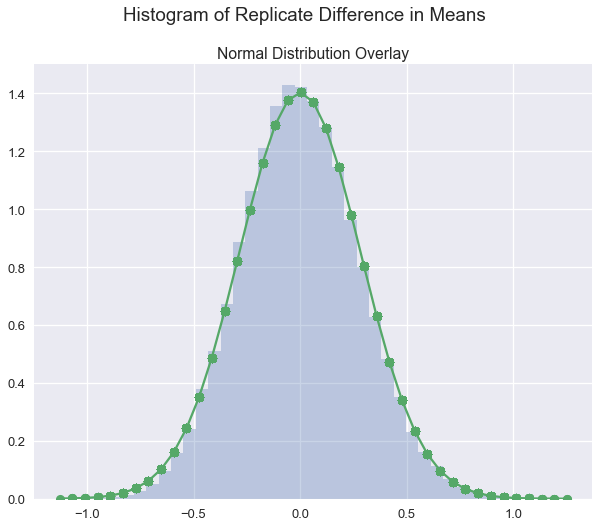

In [73]:
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.hist(perm_replicates, alpha=0.3, normed=True, bins=41)

fit = stats.norm.pdf(sorted(perm_replicates),np.mean(perm_replicates), np.std(perm_replicates))
ax.plot(sorted(perm_replicates), fit, '-o')

plt.suptitle('Histogram of Replicate Difference in Means')
plt.title('Normal Distribution Overlay')
plt.show()



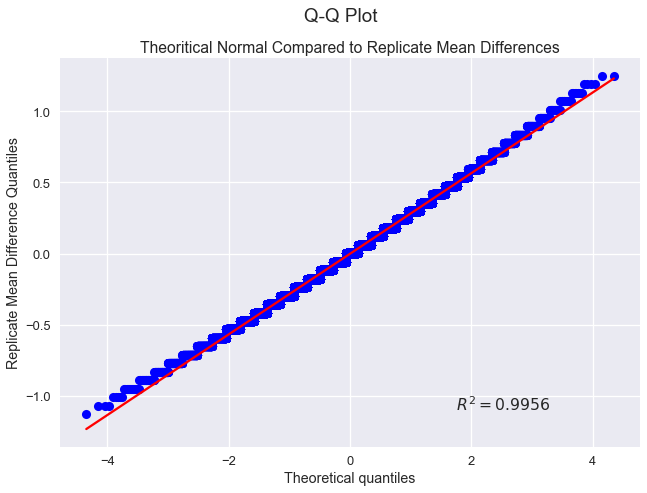

In [67]:
stats.probplot(perm_replicates, dist="norm", plot=plt, rvalue=True)
plt.title('Theoritical Normal Compared to Replicate Mean Differences')
plt.suptitle('Q-Q Plot')
plt.ylabel('Replicate Mean Difference Quantiles')
plt.show()

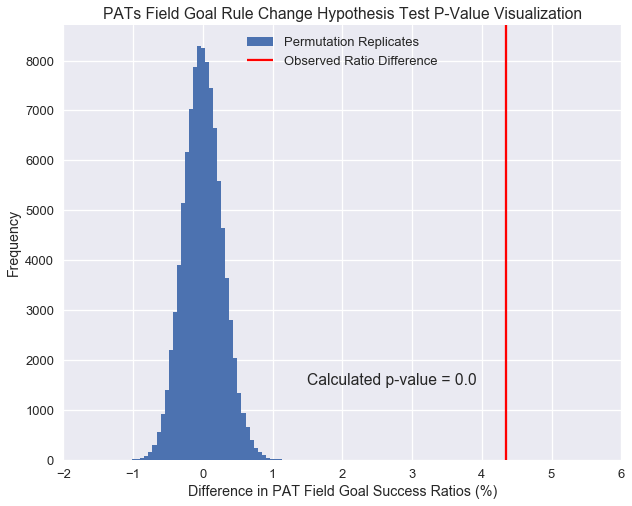

In [80]:
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.hist(perm_replicates, bins=41, normed=False, label='Permutation Replicates')
ax.set_xlim(-2.,6.)

ylim = ax.get_ylim()
ax.vlines(mean_diffs(pre, post), 0, ylim[1], colors='r', linestyles='solid', label='Observed Ratio Difference')
ax.set_ylim(ylim)

ax.text(1.5,1500,'Calculated p-value = {}'.format(p))

ax.legend(loc = 'upper center')
ax.set_xlabel('Difference in PAT Field Goal Success Ratios (%)')
ax.set_ylabel('Frequency')
ax.set_title('PATs Field Goal Rule Change Hypothesis Test P-Value Visualization')
plt.savefig('PAT HYPO TEST')
plt.show()

## Statistical Computations

In [78]:
len(pre)

6733

In [74]:
pre_good  = np.sum(np.array(pre)/100)
pre_bad   = len(pre) - pre_good
post_good = np.sum(np.array(post)/100)
post_bad  = len(post) - post_good

table = [[pre_good, pre_bad],[post_good, post_bad]]

In [75]:
mydict = {'Before Change':
          {'# Good':pre_good, 
           '# Bad':pre_bad, 
           'Success Ratio': '{0:.2f}%'.format(np.mean(pre))
          }, 
          'After Change':
          {'# Good':post_good, 
           '# Bad':post_bad, 
           'Success Ratio':'{0:.2f}%'.format(np.mean(post))
          }
         }
pd.DataFrame(mydict).loc[['# Good','# Bad','Success Ratio'],['Before Change','After Change']]

,Before Change,After Change
# Good,6713,2137
# Bad,20,104
Success Ratio,99.70%,95.36%


In [76]:
stat, chi2_p, df, expected = stats.chi2_contingency(observed=np.array(table))
stats_dict = {'P-Value':
              {'Permutation': p,
               'Chi Squared': chi2_p
              },
              'Result':
              {'Permutation': 'Reject H0',
               'Chi Squared': 'Reject H0'
              }
             }
pd.DataFrame(stats_dict)

,P-Value,Result
Chi Squared,7.171040e-52,Reject H0
Permutation,0.000000e+00,Reject H0
